<a href="https://colab.research.google.com/github/aewallwi/calamity/blob/main/examples/Calamity_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Sep 25 05:54:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# The Purpose of this Notebook

* Demonstrate how to install `calamity`.
* Show how to perform per-baseline bandpass calibration using `calibration.calibrate_and_model_dpss`. 

# Installing Calamity

You can install `calamity` and its dependancy with `pip` using the command `pip install git+https://github.com/aewallwi/calamity.git`

In [2]:
!pip install git+https://github.com/aewallwi/calamity.git --quiet

     |████████████████████████████████| 62.3 MB 2.8 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


Most of the important calibration functionality is located in the `calamity.calibration` module. You can import it as follows. We will also be using the `calamity.cal_utils` module to initialize and apply calibration solutions.





In [3]:
from calamity import cal_utils
from calamity import calibration

We'll also be using some standard python modules such as `numpy`, `scipy`, and `matplotlib` for visualization.

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import copy

### Define a Helper Visualization Function.

Here, we define a helper function to visualize delay-transformed visibilities on a grid (good proxy for power-spectrum).

In [5]:


def delay_transform_sort_by_baseline_length(uvd, tind=0, polind=0, window='blackmanharris', min_bl=0.1, fold=True):
    """
    generate an (NF x NBL) array with baselines arranged in ascending length

    Parameters
    ----------
    uvd: UVData object
        UVData with data that you want to inspect FFT of.
    polind: int, optional
        index of polarization to return.
        default is 0.
    window: str, optional
        fourier transform window function.
        default is blackman harris.
    min_bl: float, optional
        minimum baseline length to include
        default is 0.1 (meters)

    Returns
    -------
    bl_lens: array-like
        Nbls float array with lengths of each baseline.
    delays: array-like
        Nfreqs float array of delays for each baseline.
    fftd_data: array-like
        Nbls x Nfreqs array of data that has been Fourier transformed along the
        frequency axis. Baselines are arranged along baseline axis in ascending length.
    """
    data_inds = np.where(uvd.time_array == np.unique(uvd.time_array)[tind])[0]
    data = uvd.data_array[data_inds, 0, :, polind].reshape(len(data_inds), uvd.Nfreqs)
    bl_lens = np.linalg.norm(uvd.uvw_array[data_inds], axis=1)
    sorted_lens = np.argsort(bl_lens)
    data = data[sorted_lens, :]
    bl_lens = bl_lens[sorted_lens]
    data = data[bl_lens > min_bl]
    bl_lens = bl_lens[bl_lens > min_bl]
    wf = signal.windows.get_window(window, uvd.Nfreqs)
    df = np.mean(np.diff(uvd.freq_array))
    delays = 1e9 * np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs, df))
    fftd_data =  np.fft.fftshift(np.fft.fft(np.fft.fftshift(wf[None, :] * data, axes=1), axis=1), axes=1) * df
    if fold:
      fftd_data = .5 * (fftd_data[:, uvd.Nfreqs//2:] + fftd_data[:, :uvd.Nfreqs//2][:, ::-1])
      delays = delays[uvd.Nfreqs//2:]
    return bl_lens, delays, fftd_data


## Load up Test Foregrounds and EoR

In this notebook, we will be calibrating an array of 15-elements arranged in a ``Golomb ruler'' (https://en.wikipedia.org/wiki/Golomb_ruler) which is a minimall redundant array that regularly samples the UV plane.

In [6]:
from calamity.data import DATA_PATH
import glob
import os
from pyuvdata import UVData
# Our Foregrounds
uvd_fg = UVData()
uvd_fg.read_uvh5(glob.glob(os.path.join(DATA_PATH, '*nant15*gleam*.uvh5'))[0])
# Our EoR
uvd_eor = UVData()
uvd_eor.read_uvh5(glob.glob(os.path.join(DATA_PATH, '*nant15*eor*.uvh5'))[0])
uvd_eor.data_array *= 1
uvd_total = copy.deepcopy(uvd_eor)
uvd_total.data_array += uvd_fg.data_array

# Visualize the Wedge in Simulations

Lets use our helper function to show foregrounds and EoR in baseline-delay space. 

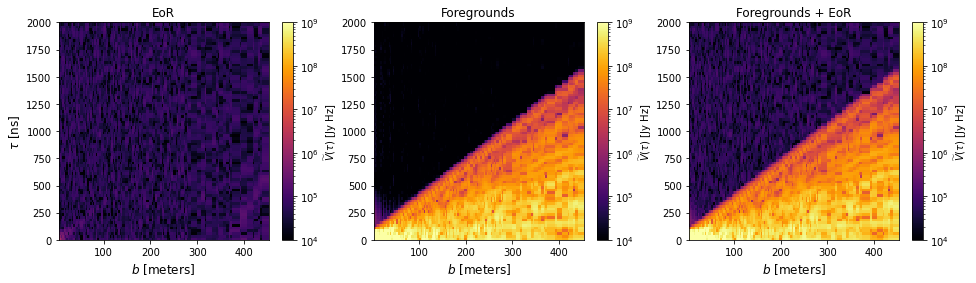

In [7]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
for uvdt, ax, label in zip([uvd_eor, uvd_fg, uvd_total], axarr, ['EoR',  'Foregrounds', 'Foregrounds + EoR', 'Corrupted Foregrounds and EoR']):
  bl, dly, wedge = delay_transform_sort_by_baseline_length(uvdt)
  blg, dlyg = np.meshgrid(bl, dly)
  plt.sca(ax)
  plt.pcolor(blg, dlyg, np.abs(wedge).T, norm=LogNorm(1e4, 1e9), cmap='inferno')
  plt.title(label)
  plt.ylim(0, 2000)
  plt.xlabel('$b$ [meters]', fontsize=12)
  if label == 'EoR':
    plt.ylabel('$\\tau$ [ns]', fontsize=12)
  plt.gca().tick_params(labelsize=10)
  plt.colorbar().set_label('$\\widetilde{V}(\\tau)$ [Jy Hz]', fontsize=10)
plt.gcf().set_size_inches(16, 4)

# Generate Uncalibrated Data

Now that we've loaded up our foreground and EoR model, lets generate some gains with random channel-to-channel variation. 

In [8]:
# generate uncalibrated data.
uvd_uncalib = copy.deepcopy(uvd_total)
# generate gains
gains = cal_utils.blank_uvcal_from_uvdata(uvd_uncalib)
gains.gain_array = gains.gain_array + 1e-1 * np.random.randn(*gains.gain_array.shape) + 1e-1j * np.random.randn(*gains.gain_array.shape)
# apply gains
uvd_uncalib = cal_utils.apply_gains(uvd_uncalib, gains, inverse=True)

Here are some plots of our gains. The solid lines are the real parts, the dashed lines are the imaginary parts. These gains have significant spectral structure that would confound traditional radio astronomy calibration algorithms (at least at the level that is needed for 21cm cosmology). 

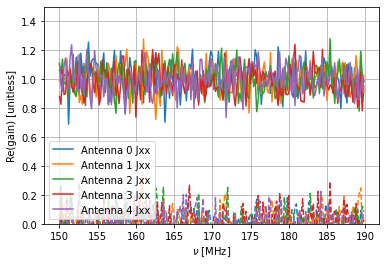

In [9]:
for antnum in range(5):
  l0 = plt.plot(gains.freq_array[0] / 1e6, gains.get_gains(antnum, 'Jxx').real.T[0], label=f'Antenna {antnum} Jxx')[0]
  plt.plot(gains.freq_array[0] / 1e6, gains.get_gains(antnum, 'Jxx').imag.T[0], ls='--', color=l0.get_color())
plt.ylim(0., 1.5)
plt.xlabel('$\\nu$ [MHz]')
plt.ylabel('Re(gain) [unitless]')
plt.grid()
plt.legend()

Plotting the real spectra for a handful of baselines, we see that our uncalibrated data has lots of spurious fine-frequency spectral structures (thick lines) in the below plot. 

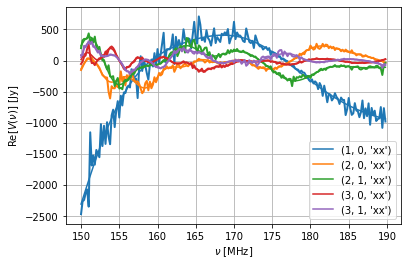

In [10]:
for bl in uvd_uncalib.get_antpairpols()[:5]:
  l0 = plt.plot(uvd_total.freq_array[0] / 1e6, uvd_total.get_data(bl)[0].real, label=f'{bl}')[0]
  plt.plot(uvd_total.freq_array[0] / 1e6, uvd_uncalib.get_data(bl)[0].real, color=l0.get_color(), lw=2)
plt.xlabel('$\\nu$ [MHz]')
plt.ylabel('Re[$V(\\nu)$] [Jy]')
plt.grid()
plt.legend()

When we make a wedge plot of this data, we see that the EoR window (region above the wedge on the left hand plot below) is now filled in with gain artifacts. 

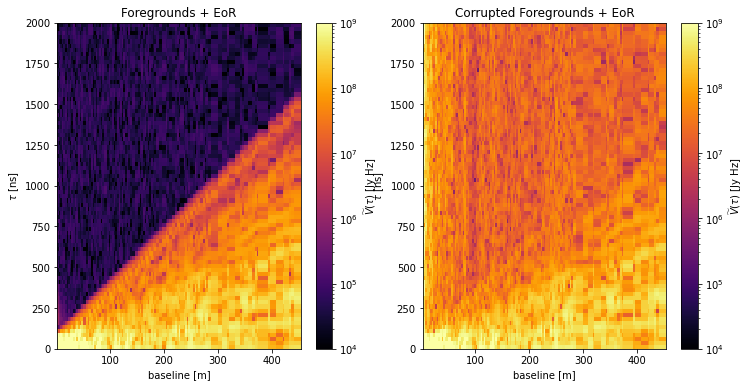

In [11]:
fig, axarr = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
for uvdt, ax, label in zip([uvd_total, uvd_uncalib], axarr, ['Foregrounds + EoR', 'Corrupted Foregrounds + EoR']):
  bl, dly, wedge = delay_transform_sort_by_baseline_length(uvdt)
  blg, dlyg = np.meshgrid(bl, dly)
  plt.sca(ax)
  plt.pcolor(blg, dlyg, np.abs(wedge).T, norm=LogNorm(1e4, 1e9), cmap='inferno')
  plt.title(label)
  plt.ylim(0, 2000)
  plt.xlabel('baseline [m]')
  plt.ylabel('$\\tau$ [ns]')
  plt.colorbar().set_label('$\\widetilde{V}(\\tau)$ [Jy Hz]', fontsize=10)


# Calibrate Data.

Now that we've cooked up some gain-corrupted data, lets try calibrating it with the `calamity.calibration.calibrate_and_model_dpss` function. This returns fitted models, residuals, and gains as `UVData` and `UVCal` objects. You feed it `UVData` objects for the data you wish to calibrate along with (optional) `UVCal` and `UVData` objects containing initial guesses for gains and foregrounds. 

In [12]:
gains_0 = cal_utils.blank_uvcal_from_uvdata(uvd_uncalib)
model_fit, resid_fit, gains_fit, fitting_info = calibration.calibrate_and_model_dpss(min_dly=2./.3, offset=2./.3, 
                                                                                uvdata=uvd_uncalib, sky_model=uvd_uncalib, freeze_model=False, 
                                                                                gains=gains_0, notebook_progressbar=True, correct_resid=True, correct_model=True,
                                                                                learning_rate=1e-2, verbose=False,
                                                                                use_redundancy=False)

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Using <class 'numpy.float32'> precision.
2021-09-25 05:56:09.056258 Provided the following opt_kwargs
learning_rate: 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

Plot the MSE between our model and the simulated visibilities as a function of iteration.

Text(0, 0.5, 'MSE')

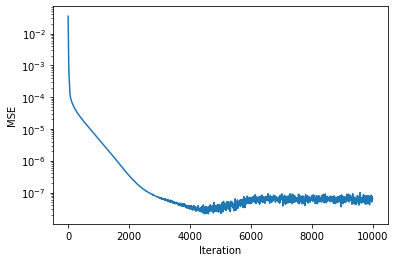

In [13]:
plt.plot(np.abs(fitting_info[0][0]['loss']))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('MSE')

Lets see how well we did. First, compare gains. It is clear that the fitted gains do not agree exactly with the true gains. This is because of frequency dependent degeneracies that still exist between the foreground model, gains and the measured visibilities. As we can see, our gain estimates don't agree terribly well with the true gains and the residuals have lots of high delay power. Did our technique actually work?

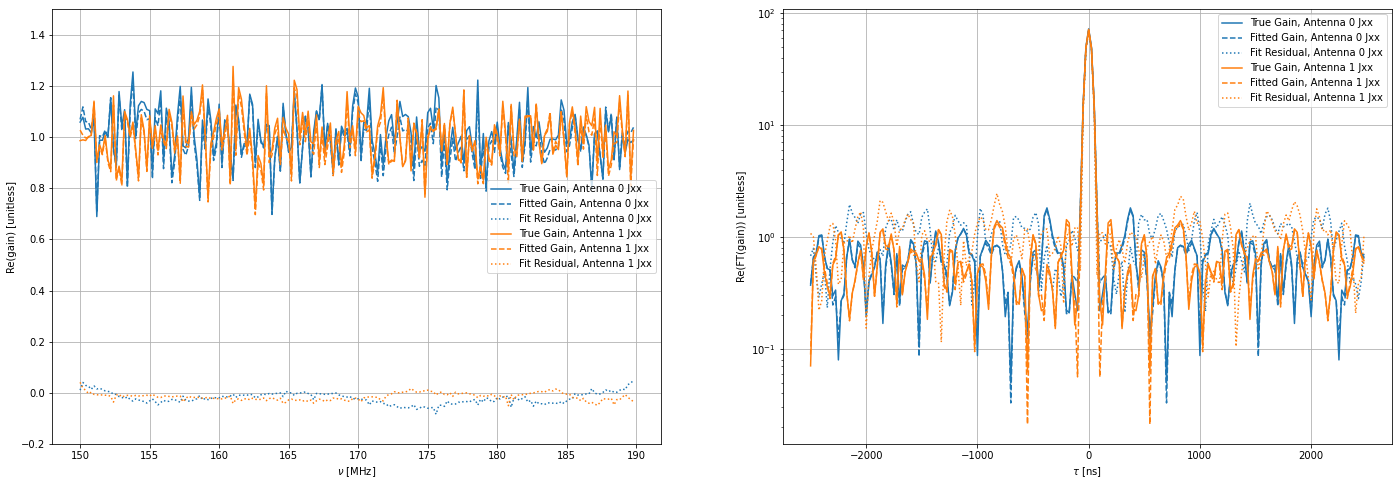

In [14]:
def fft_bh(data):
  """
  take a 1d fft multiplied by a blackmanharris
  """
  window = signal.windows.blackmanharris(len(data))
  return np.fft.fftshift(np.fft.fft(np.fft.fftshift(data * window)))


fig, axarr = plt.subplots(1, 2)
fig.set_size_inches(24, 8)
plt.sca(axarr[0])
for antnum in range(2):
  l0 = plt.plot(gains.freq_array[0] / 1e6, gains.get_gains(antnum, 'Jxx').real.T[0], label=f'True Gain, Antenna {antnum} Jxx')[0]
  plt.plot(gains_fit.freq_array[0] / 1e6, gains_fit.get_gains(antnum, 'Jxx').real.T[0], 
           label=f'Fitted Gain, Antenna {antnum} Jxx', color=l0.get_color(), ls='--')[0]
  plt.plot(gains_fit.freq_array[0] / 1e6, gains_fit.get_gains(antnum, 'Jxx').real.T[0] - gains.get_gains(antnum, 'Jxx').real.T[0], 
           label=f'Fit Residual, Antenna {antnum} Jxx', color=l0.get_color(), ls=':')[0]
plt.ylim(-.2, 1.5)
plt.xlabel('$\\nu$ [MHz]')
plt.ylabel('Re(gain) [unitless]')
plt.grid()
plt.legend()

plt.sca(axarr[1])
delays = np.fft.fftshift(np.fft.fftfreq(gains.Nfreqs, np.mean(np.diff(gains.freq_array)))) * 1e9

for antnum in range(2):
  l0 = plt.plot(delays, np.abs(fft_bh(gains.get_gains(antnum, 'Jxx').real.T[0])),
                label=f'True Gain, Antenna {antnum} Jxx')[0]
  plt.plot(delays, np.abs(fft_bh(gains_fit.get_gains(antnum, 'Jxx').real.T[0])),
           label=f'Fitted Gain, Antenna {antnum} Jxx', color=l0.get_color(), ls='--')[0]
  plt.plot(delays, np.abs(fft_bh(gains_fit.get_gains(antnum, 'Jxx').real.T[0]) - gains.get_gains(antnum, 'Jxx').real.T[0]), 
           label=f'Fit Residual, Antenna {antnum} Jxx', color=l0.get_color(), ls=':')[0]
#plt.ylim(-.2, 1.5)
plt.yscale('log')
plt.xlabel('$\\tau$ [ns]')
plt.ylabel('Re(FT(gain)) [unitless]')
plt.grid()
plt.legend()

A key strategy in our technique is that we do not solve for the gains perfectly but instead force the ratio between the measured visibilities and the gain pairs (our estimate of the true foregrounds) to stay within the wedge. It doesn't matter if our gains don't agree perfectly with the true gains. What does matter is that the delay-spectrum of the data on a short baseline divided by the product of gains stays within the wedge.


Calamity does not enforce gain smoothness -- it enforces calibrated foreground smoothness, which is what we really care about.

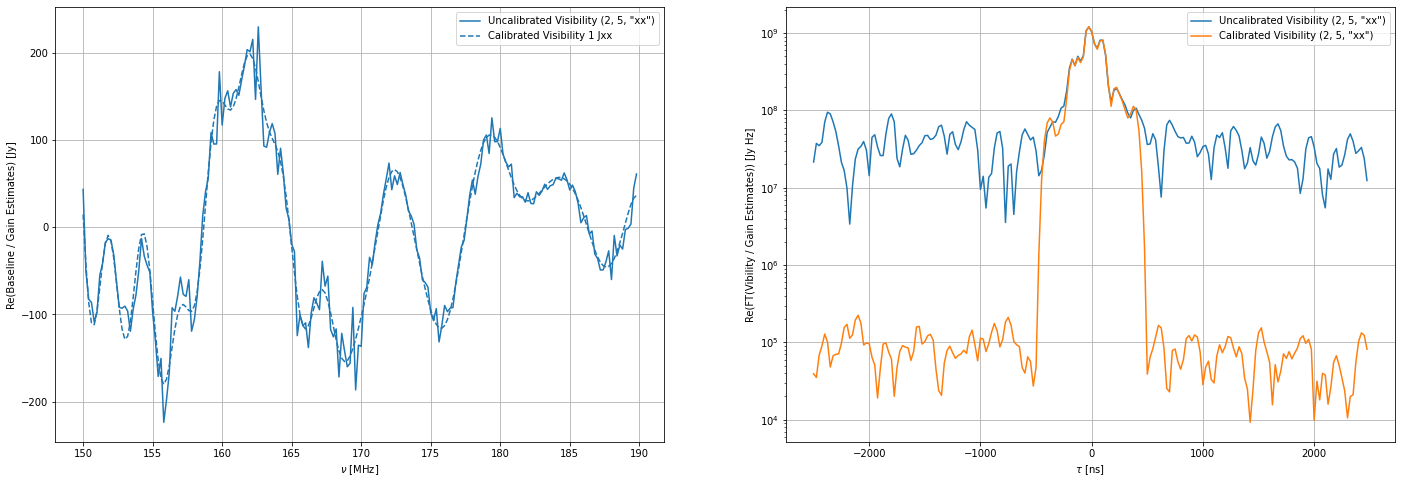

In [15]:

fig, axarr = plt.subplots(1, 2)
fig.set_size_inches(24, 8)
plt.sca(axarr[0])
a0 = 2
a1 = 5
calibrated_slice = np.real(uvd_uncalib.get_data(a0, a1, 'xx')[0] \
              /(gains_fit.get_gains(a0, 'Jxx').T[0] * np.conj(gains_fit.get_gains(a1, 'Jxx').T[0])))

l0 = plt.plot(gains.freq_array[0] / 1e6, uvd_uncalib.get_data(a0, a1, 'xx')[0].real, label=f'Uncalibrated Visibility ({a0}, {a1}, "xx")')[0]
plt.plot(gains.freq_array[0] / 1e6, calibrated_slice,
              label=f'Calibrated Visibility {antnum} Jxx', color=l0.get_color(), ls='--')
  
plt.xlabel('$\\nu$ [MHz]')
plt.ylabel('Re(Baseline / Gain Estimates) [Jy]')
plt.grid()
plt.legend()


plt.sca(axarr[1])
delays = np.fft.fftshift(np.fft.fftfreq(gains.Nfreqs, np.mean(np.diff(gains.freq_array)))) * 1e9

df = np.mean(np.diff(uvd_uncalib.freq_array))
l0 = plt.plot(delays, np.abs(fft_bh(uvd_uncalib.get_data(a0, a1, 'xx')[0])) * df,
              label=f'Uncalibrated Visibility ({a0}, {a1}, "xx")')[0]

plt.plot(delays, np.abs(fft_bh(uvd_uncalib.get_data(a0, a1, 'xx')[0] * df\
         /(gains.get_gains(a0, 'Jxx').T[0] * np.conj(gains.get_gains(a1, 'Jxx').T[0])))),
         label=f'Calibrated Visibility ({a0}, {a1}, "xx")')[0]
#plt.ylim(-.2, 1.5)
plt.yscale('log')
plt.xlabel('$\\tau$ [ns]')
plt.ylabel('Re(FT(Vibility / Gain Estimates)) [Jy Hz]')
plt.grid()
plt.legend()


Next, lets plot the calibrated wedge.

In [16]:
uvd_calib = cal_utils.apply_gains(uvd_uncalib, gains_fit, inverse=False)

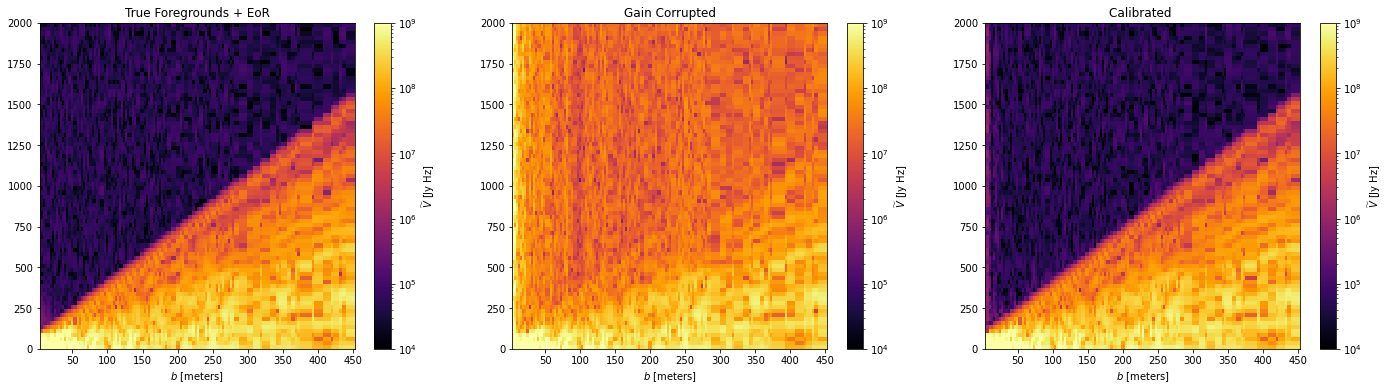

In [26]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
for uvdt, ax, label in zip([uvd_total, uvd_uncalib, uvd_calib], axarr, 
                           ['True Foregrounds + EoR', 'Gain Corrupted', 'Calibrated ']):
  bl, dly, wedge = delay_transform_sort_by_baseline_length(uvdt)
  blg, dlyg = np.meshgrid(bl, dly)
  plt.sca(ax)
  plt.pcolor(blg, dlyg, np.abs(wedge).T, norm=LogNorm(1e4, 1e9), cmap='inferno')
  plt.title(label)
  plt.ylim(0, 2000)
  plt.colorbar(label='$\\widetilde{V}$ [Jy Hz]')
  if label == 'EoR':
    plt.ylabel('$\\tau$ [ns]')
  plt.xlabel('$b$ [meters]')